# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [164]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, val_loader, test_loader
    

In [165]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

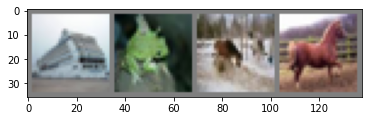

ship frog horse horse


In [166]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [225]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self, image_channels=3, out_channels=32):
        super().__init__()
        self.conv1 = nn.Conv2d(  # 3 x 32 x 32
            in_channels=image_channels, out_channels=out_channels, kernel_size=1
        ) # 32 x 32 x 32
        self.basic_block = nn.Sequential( # 3 x 32 x 32
            nn.Conv2d(in_channels=image_channels, out_channels=out_channels, kernel_size=3, padding=1), # 32 x 32 x 32
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1), # 32 x 32 x 32
            nn.BatchNorm2d(num_features=out_channels) 
        ) # 32 x 32 x 32
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size=5,stride=7) 
        self.linear = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        residual = self.conv1(x) # 32 x 32 x 32
        basic_out = self.basic_block(x) # 32 x 32 x 32
        pooled_out = self.avgpool(self.relu(basic_out + residual)) # 32 x 4 x 4
        out = self.linear(pooled_out.flatten(start_dim=1)) # 512
        return out

In [224]:
# image_channels=3
# out_channels=32
# x = images[0]
# x = torch.zeros((10, 3, 32, 32))

# conv1 = nn.Conv2d(  # 3 x 32 x 32
#     in_channels=image_channels, out_channels=out_channels, kernel_size=1
# ) # 32 x 32 x 32
# basic_block = nn.Sequential( # 3 x 32 x 32
#     nn.Conv2d(in_channels=image_channels, out_channels=out_channels, kernel_size=3, padding=1), # 32 x 32 x 32
#     nn.BatchNorm2d(num_features=out_channels),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1), # 32 x 32 x 32
#     nn.BatchNorm2d(num_features=out_channels) 
# ) # 32 x 32 x 32
# relu = nn.ReLU()
# avgpool = nn.AvgPool2d(kernel_size=5,stride=7)
# linear = nn.Linear(in_features=512, out_features=n_classes)

# residual = conv1(x)
# basic_out = basic_block(x)
# pooled_out = avgpool(relu(basic_out + residual))
# pooled_out.shape
# # linear(pooled_out.flatten(start_dim=1))

In [215]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv1): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (basic_block): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=5, stride=7, padding=0)
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

In [223]:
# x = torch.zeros((10, 3, 32, 32))

# a = nn.Conv2d(in_channels=image_channels, out_channels=out_channels, kernel_size=3, padding=1) # 32 x 32 x 32     # A
# b = nn.BatchNorm2d(num_features=out_channels)           # B
# c = nn.ReLU()                             # C
# d = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1) # 3 x 28 x 28      # D
# e = nn.BatchNorm2d(num_features=out_channels)

# e(d(c(b(a(x))))).shape

Проверим, что выход сети имеет корректную размерность:

In [216]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [226]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [227]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [239]:
import torch.nn.functional as F

loss_fn = F.cross_entropy

@torch.inference_mode()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    for data, target in loader:     
        data, target = data.to(device), target.to(device)
        logits = model(data)
        loss = loss_fn(logits, target)
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum()  / data.shape[0]
        acc_log.append(acc.item()) 
    
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_fn(logits, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [240]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.0005261408781438, train acc: 0.6496474275423361
 val loss: 1.0771029741206068, val acc: 0.6298537234042553

Epoch 1
 train loss: 0.98312967579805, train acc: 0.65706614003103
 val loss: 1.060277756477924, val acc: 0.6289007093044038

Epoch 2
 train loss: 0.9614740800813958, train acc: 0.6646644032851433
 val loss: 1.0261919518734546, val acc: 0.6508643617021277

Epoch 3
 train loss: 0.9534730055868299, train acc: 0.6680064965209752
 val loss: 1.0215750673983959, val acc: 0.6480718085106383

Epoch 4
 train loss: 0.9352009158029853, train acc: 0.6738010904252856
 val loss: 1.009555352241435, val acc: 0.6534352837724888

Epoch 5
 train loss: 0.9274250806140726, train acc: 0.6776165447897623
 val loss: 1.0132625754843367, val acc: 0.6587544327086591

Epoch 6
 train loss: 0.9183368317823741, train acc: 0.6804934382656592
 val loss: 1.0032423311091483, val acc: 0.657535461161999

Epoch 7
 train loss: 0.900890240394655, train acc: 0.6887854204753199
 val loss: 1.0014369

Посчитайте точность на тестовой выборке:

In [244]:
_, acc = test(net, test_loader)
print(f'Accuracy test: {acc:.4f}')

Accuracy test: 0.6633


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

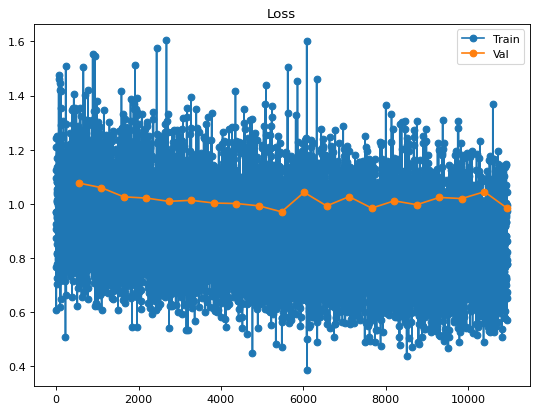

In [263]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=80)
plt.plot(range(len(train_loss_log)), train_loss_log, marker='o', label='Train')
plt.plot([(i+1) * (len(train_loss_log) / 20) for i in range(len(val_loss_log))], val_loss_log, marker='o', label='Val')
plt.legend()
plt.title('Loss')
plt.show()

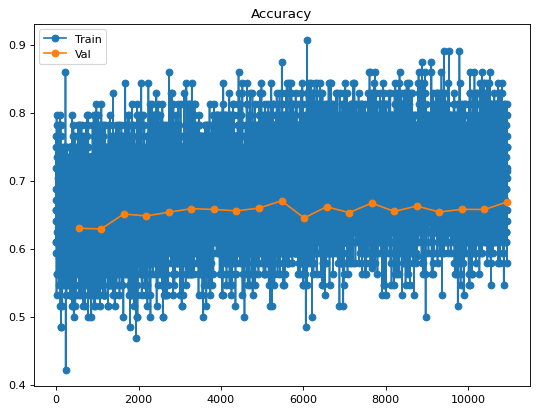

In [262]:
figure(figsize=(8, 6), dpi=80)
plt.plot(range(len(train_acc_log)), train_acc_log, marker='o', label='Train')
plt.plot([(i+1) * (len(train_acc_log) / 20) for i in range(len(val_acc_log))], val_acc_log, marker='o', label='Val')
plt.legend()
plt.title('Accuracy')
plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [264]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5286118591943214, train acc: 0.4530841930474834
 val loss: 1.4365177250922994, val acc: 0.49911347526185057

Epoch 1
 train loss: 1.2861459553786563, train acc: 0.5485888939670932
 val loss: 1.214747378927596, val acc: 0.5821143617021277

Epoch 2
 train loss: 1.1703606341613058, train acc: 0.5910240924990373
 val loss: 1.1605941658324384, val acc: 0.5961879433469569

Epoch 3
 train loss: 1.1221398233931505, train acc: 0.6042822865289134
 val loss: 1.1117593346758092, val acc: 0.6149157803109352

Epoch 4
 train loss: 1.072954463566461, train acc: 0.62287395538752
 val loss: 1.1151598007120984, val acc: 0.6039671986661059

Epoch 5
 train loss: 1.0493073656310548, train acc: 0.6352343954813328
 val loss: 1.0454017687351145, val acc: 0.6379654255319149

Epoch 6
 train loss: 1.0254432227755377, train acc: 0.6426571886543818
 val loss: 1.0336366721924315, val acc: 0.64350620584285

Epoch 7
 train loss: 1.0026569854624747, train acc: 0.6487619156593378
 val loss: 1.0857

Посчитайте точность на тестовой выборке:

In [265]:
_, acc = test(net, test_loader)
print(f'Accuracy test: {acc:.4f}')

Accuracy test: 0.6699


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [267]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

_, acc = test(net, test_loader)
print(f'Accuracy test: {acc:.4f}')

Epoch 0
 train loss: 1.801879458061302, train acc: 0.3652552886026651
 val loss: 1.6009621675978316, val acc: 0.4361037234042553

Epoch 1
 train loss: 1.5182381600304975, train acc: 0.4638368372943327
 val loss: 1.442415829415017, val acc: 0.4882535461415636

Epoch 2
 train loss: 1.4050146751037682, train acc: 0.5028768934758969
 val loss: 1.3618394400211091, val acc: 0.5208333335024246

Epoch 3
 train loss: 1.3402606028743373, train acc: 0.5280017629401993
 val loss: 1.3382351641959331, val acc: 0.5199689716734784

Epoch 4
 train loss: 1.2943272551409288, train acc: 0.5456303865861631
 val loss: 1.2711362285816923, val acc: 0.5511746454746165

Epoch 5
 train loss: 1.2528817034726605, train acc: 0.5600311765941013
 val loss: 1.2354518738198788, val acc: 0.5654698582405739

Epoch 6
 train loss: 1.2209600229803779, train acc: 0.5726772656824297
 val loss: 1.2190124420409507, val acc: 0.5716533688788719

Epoch 7
 train loss: 1.1923447670840694, train acc: 0.5832381170018281
 val loss: 1.1

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
# <your code here>

Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

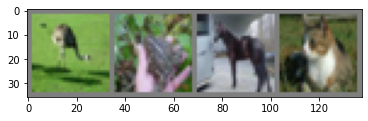

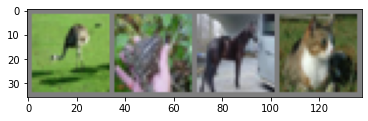

In [269]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [270]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5089467378159547, train acc: 0.46482436672207206
 val loss: 1.334872185423019, val acc: 0.5195921986661058

Epoch 1
 train loss: 1.2461366094444526, train acc: 0.5641771676989317
 val loss: 1.2260842024011815, val acc: 0.5661125886947551

Epoch 2
 train loss: 1.1528301616037568, train acc: 0.5967982828726063
 val loss: 1.1319603121027033, val acc: 0.6021276595744681

Epoch 3
 train loss: 1.1037862068774278, train acc: 0.6155286955441156
 val loss: 1.147121110621919, val acc: 0.6097960994598713

Epoch 4
 train loss: 1.071825160949714, train acc: 0.6274769848835752
 val loss: 1.0888295199008697, val acc: 0.6194148936170213

Epoch 5
 train loss: 1.0468862650599298, train acc: 0.6360872617805244
 val loss: 1.092262187663545, val acc: 0.624312943346957

Epoch 6
 train loss: 1.0170559031000086, train acc: 0.6441058370487346
 val loss: 1.0307847116855864, val acc: 0.6416888297872341

Epoch 7
 tr

Посчитайте точность на тестовой выборке:

In [271]:
_, acc = test(net, test_loader)
print(f'Accuracy test: {acc:.4f}')

Accuracy test: 0.6892


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [272]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         torchvision.transforms.RandomPerspective(),
         transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7643855145470098, train acc: 0.36301906507673387
 val loss: 1.5963271978053641, val acc: 0.4225842199427016

Epoch 1
 train loss: 1.5899946659095108, train acc: 0.42678000133695726
 val loss: 1.5485930574701188, val acc: 0.4336657801841168

Epoch 2
 train loss: 1.5103092424612377, train acc: 0.45816466446550497
 val loss: 1.532505554848529, val acc: 0.455141844013904

Epoch 3
 train loss: 1.4661980727908817, train acc: 0.4742548642254399
 val loss: 1.435916997524018, val acc: 0.4875664893617021

Epoch 4
 train loss: 1.4166713645732816, train acc: 0.4926996279024337
 val loss: 1.4348670452199084, val acc: 0.4875

Epoch 5
 train loss: 1.3926751188647812, train acc: 0.5015180204642539
 val loss: 1.3998275832926974, val acc: 0.4997562057160317

Epoch 6
 train loss: 1.374160113456698, train acc: 0.5072595652540162
 val loss: 1.364214930128544, val acc: 0.5166001773895101

Epoch 7
 train loss: 

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>